In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=60100faa8ebe81f5f09d6a2384ff40bfc25b352313f1f4ad68806a12df40c746
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import pandas as pd

## Step 1: Creating a SparkSession

In [ ]:
spark = SparkSession.builder.appName("Customer segmentation").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

## Step 2: Creating the DataFrame

In [ ]:
# Read the Excel file using pandas
excel_data = pd.read_excel('Online Retail.xlsx')

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(excel_data)

## Step 3:Exploratory Data Analysis

In [ ]:
spark_df.show(5,0)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
+---------+-----

In [ ]:
spark_df.count()

541909

In [ ]:
spark_df.select('CustomerID').distinct().count()

4373

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark_df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           88|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            5|
|             Italy|           15|
|              EIRE|            4|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            1|
|           Iceland|            1|
|            Israel|            5|
+------------------+-------------+
only showing top 20 rows



In [ ]:
#country from which most purchases are made
spark_df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3951|
|        Germany|           95|
|         France|           88|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           22|
|       Portugal|           20|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|    Unspecified|            5|
+---------------+-------------+
only showing top 20 rows



In [ ]:
# latest purchase made on the platform
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
spark_df = spark_df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
spark_df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [ ]:
#earliest purchase made by a customer on the e-commerce platform
spark_df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



## Step 4: Data Pre-processing

In [ ]:
#Assigning a recency score to each customer
spark_df = spark_df.withColumn("from_date", lit("12/1/10 08:26"))
spark_df = spark_df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=spark_df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [ ]:
#Selecting the most recent purchase
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df2.show(5,0)

+---------+---------+---------+------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|recency  |InvoiceNo|StockCode|Description             |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |date               |from_date          |
+---------+---------+---------+------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|-27704940|544815   |22421    |LIPSTICK PEN FUSCHIA    |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22419    |LIPSTICK PEN RED        |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22420    |LIPSTICK PEN BABY PINK  |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22077  

In [ ]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [ ]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [ ]:
# frequency - how often a customer bought something on the platform
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|12493.0   |11       |
|18114.0   |28       |
|13533.0   |33       |
|13973.0   |11       |
|13956.0   |21       |
+----------+---------+
only showing top 5 rows



In [ ]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [ ]:
#Printing schema
df3.printSchema()

root
 |-- CustomerID: double (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [ ]:
#total amount spent in each purchase
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [ ]:
#total amount spent by each customer
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [ ]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [ ]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [ ]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

## Standardization

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [ ]:
data_scale_output.select('standardized').show(2,truncate=False)

+-------------------------------------------------------------+
|standardized                                                 |
+-------------------------------------------------------------+
|[-0.4234668872396715,0.1385858749776728,0.09925473358128202] |
|[-1.0867760420169081,0.11779799373102189,0.11509797044420902]|
+-------------------------------------------------------------+
only showing top 2 rows



## Step 5: Building the Machine Learning Model

In [ ]:
#i) Finding the number of clusters to use
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

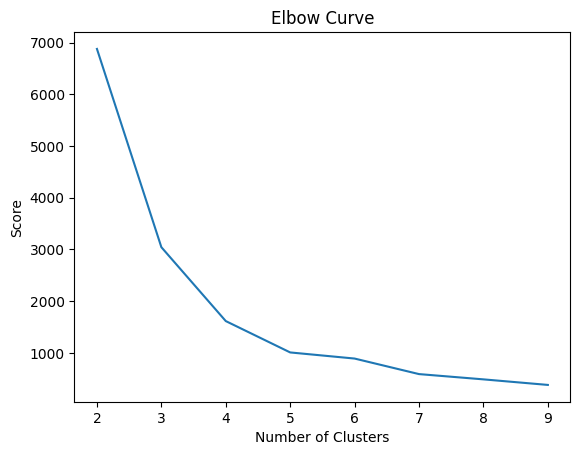

In [ ]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
#ii) Building the K-Means Clustering Model
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [ ]:
#iii) Making Predictions
preds=KMeans_fit.transform(data_scale_output)
preds.show(5,0)

+---------+---------+------------------+----------+-------------------------------------+-------------------------------------------------------------+----------+
|recency  |frequency|monetary_value    |CustomerID|features                             |standardized                                                 |prediction|
+---------+---------+------------------+----------+-------------------------------------+-------------------------------------------------------------+----------+
|-17014140|11       |184.29000000000002|12493.0   |[-1.701414E7,11.0,184.29000000000002]|[-1.9483723024997794,0.03811111561886002,0.04125689022847001]|4         |
|-19334460|11       |184.29000000000002|12493.0   |[-1.933446E7,11.0,184.29000000000002]|[-2.2140834827849005,0.03811111561886002,0.04125689022847001]|4         |
|-27803160|28       |220.1             |18114.0   |[-2.780316E7,28.0,220.1]             |[-3.183875697858944,0.09701011248437097,0.049273653151479996]|2         |
|-18477120|33       |1

## Step 6: Cluster Analysis

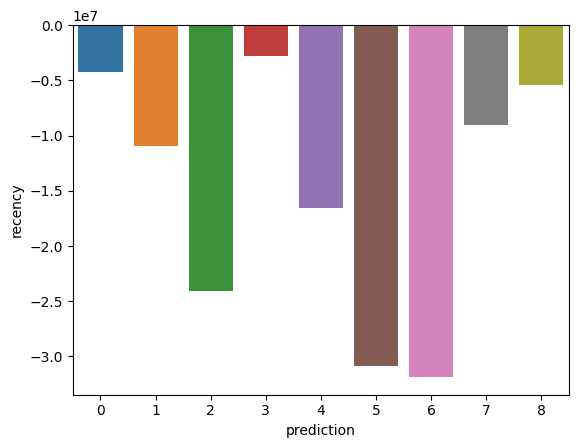

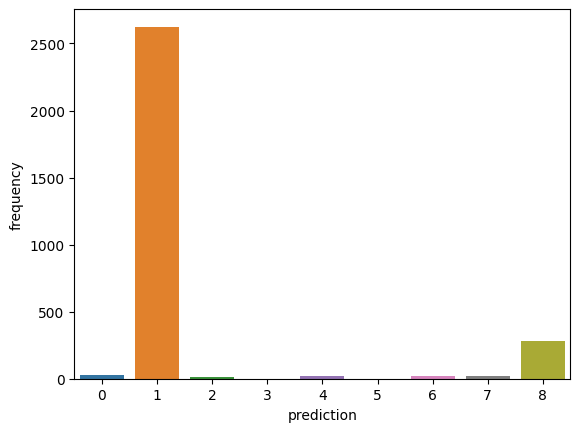

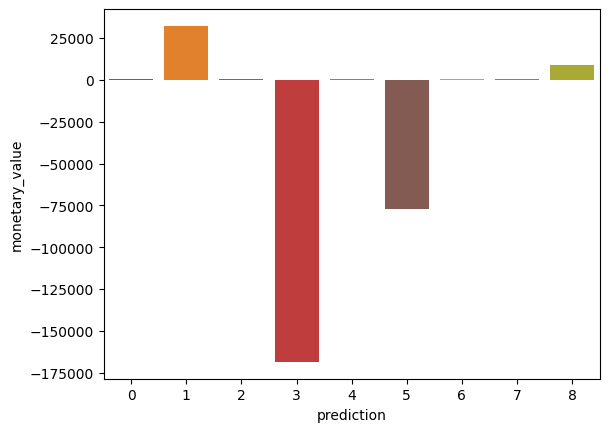

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

Here is an overview of characteristics displayed by customers in each cluster:

Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.

Cluster 1: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.

Cluster 2: Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.

Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.